In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys
import os

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from CosineTuning import *
from lineplots import plotsd
from sklearn.model_selection import KFold
from plotting_utils import figSize

files = glob.glob('D:/T5_ClosedLoop/*')
dat   = DataStruct(files[1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


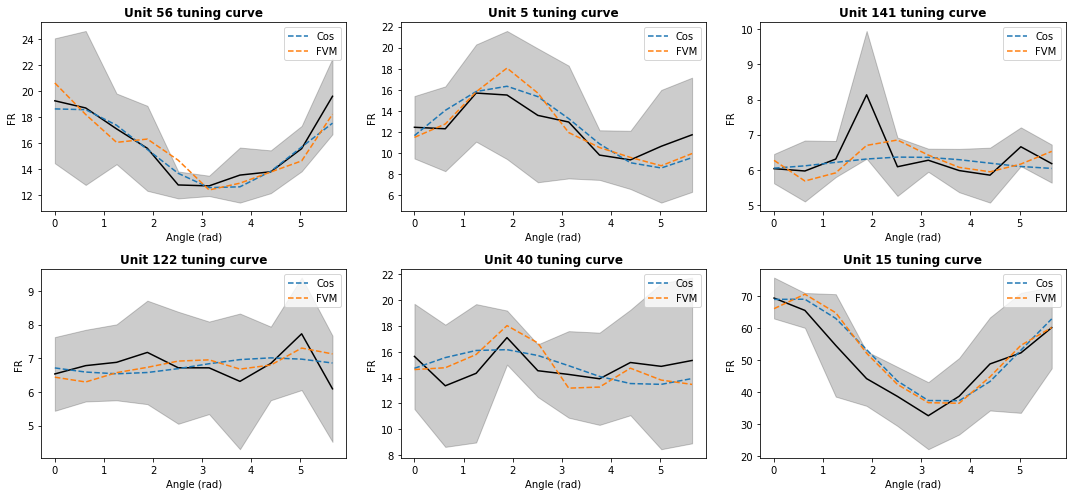

In [7]:
figSize(7, 15)
#np.random.seed(40)


# Tuning curve plotting:
n_bins     = 10
cv         = 5

# Von Mises model parameters:
n_basis = 20
kappa   = 0.001

#---------------------------------
neural, _, vel_signal, _ = getTrainTest(dat, train_frac = 1, task = 'keyboard')
vel_angle                = getAngles(vel_signal, returnFullAngle = True)
split                    = int(vel_angle.shape[0] / 2)

for i, unit in enumerate(np.random.choice(192, 6)):
    unit_data            = neural[:, unit]
    FR_estimates, labels = fitTuningCurve(neural = unit_data, traj = vel_signal, n_AngleBins = n_bins, cv = cv)
    
    cos   = CosineTuningModel().fit(vel_angle, unit_data)
    vm    = FlexibleVonMisesModel(n_basis = n_basis, kappa = kappa).fit(vel_angle, unit_data)
    
    preds_cos = cos.predict(labels)
    preds_vm  = vm.predict(labels)
       
    plt.subplot(2, 3, i + 1)
    plotsd(data = FR_estimates.T, color = 'k', time_bins = labels)
    plt.plot(labels, preds_cos, linestyle = '--', label = 'Cos')
    plt.plot(labels, preds_vm, linestyle = '--', label = 'FVM')
    plt.title('Unit ' + str(unit) + ' tuning curve', fontweight = 'bold')
    plt.xlabel('Angle (rad)')
    plt.ylabel('FR')
    plt.legend()
plt.tight_layout()

In [28]:
dat   = DataStruct(files[10])
print(np.unique(dat.trialType))

['cursor' 'keyboard']


Optimal number of basis functions:  6
Optimal dispersion parameter:  0.01


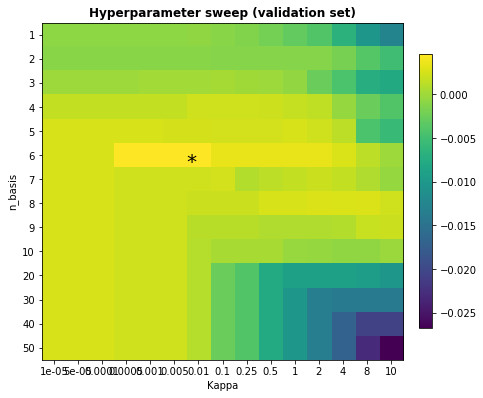

In [29]:
from scipy.ndimage import gaussian_filter1d


dat   = DataStruct(files[10])

task        = 'keyboard'
basis_sweep = [1, 2, 3, 4, 5, 6, 7 ,8, 9, 10, 20, 30, 40, 50]
kappa_sweep = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 2, 4, 8, 10]

train = 10000
val   = 12000
test  = 15000


neural, _, vel_signal, _ = getTrainTest(dat, train_frac = 1, task = task)
neural                   = gaussian_filter1d(neural.astype('float'), 2, axis= 0)
vel_angle                = getAngles(vel_signal, returnFullAngle = True)
train_x, val_x           = vel_angle[:train], vel_angle[train:val]

cos_scores      = np.zeros((192,)) 
vm_scores       = np.zeros((len(basis_sweep), len(kappa_sweep), 192))
mean_FRs        = np.zeros((3, 192))

for i in range(192):
    unit_data                = neural[:, i].astype('float')
    train_y, val_y, test_y   = unit_data[:train], unit_data[train:val], unit_data[val:test]
    mean_FRs[0, i]   = train_y.mean()
    mean_FRs[1, i]   = val_y.mean()
    mean_FRs[2, i]   = test_y.mean()

    cos              = CosineTuningModel().fit(train_x, train_y)
    cos_scores[i]    = cos.score(val_x, val_y)
    
    for j, n_basis in enumerate(basis_sweep):
        for k, kappa in enumerate(kappa_sweep):
            vm                 = FlexibleVonMisesModel(n_basis = n_basis, kappa = kappa).fit(train_x, train_y)
            vm_scores[j, k, i] = vm.score(val_x, val_y)

grid_meanscores         = np.median(vm_scores - cos_scores, axis = 2)
opt_B_ind, opt_K_ind    = np.unravel_index(grid_meanscores.argmax(), grid_meanscores.shape)
opt_B, opt_K            = basis_sweep[opt_B_ind], kappa_sweep[opt_K_ind]
print('Optimal number of basis functions: ', opt_B)
print('Optimal dispersion parameter: ', opt_K)

figSize(7, 7)
im = plt.imshow(grid_meanscores)
plt.text(opt_K_ind - 0.5, opt_B_ind + 0.5, '*', fontsize = 20)
plt.title('Hyperparameter sweep (validation set)', fontweight = 'bold')
plt.xlabel('Kappa')
plt.ylabel('n_basis')
plt.colorbar(im, fraction=0.035, pad=0.04)
ax = plt.gca()
_  = ax.set_xticks(np.arange(len(kappa_sweep)))
_  = ax.set_yticks(np.arange(len(basis_sweep)))
_  = ax.set_xticklabels(kappa_sweep,)
_  = ax.set_yticklabels(basis_sweep)

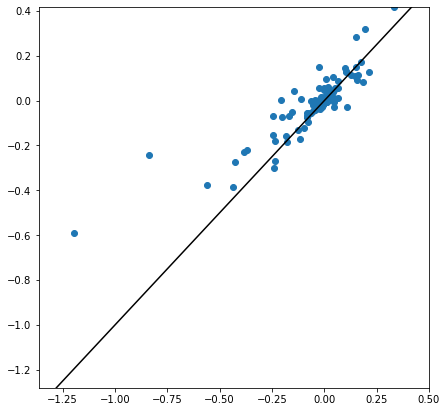

In [12]:
plt.scatter(cos_scores, vm_scores[opt_B_ind, opt_K_ind, :])
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim(), color  = 'k')

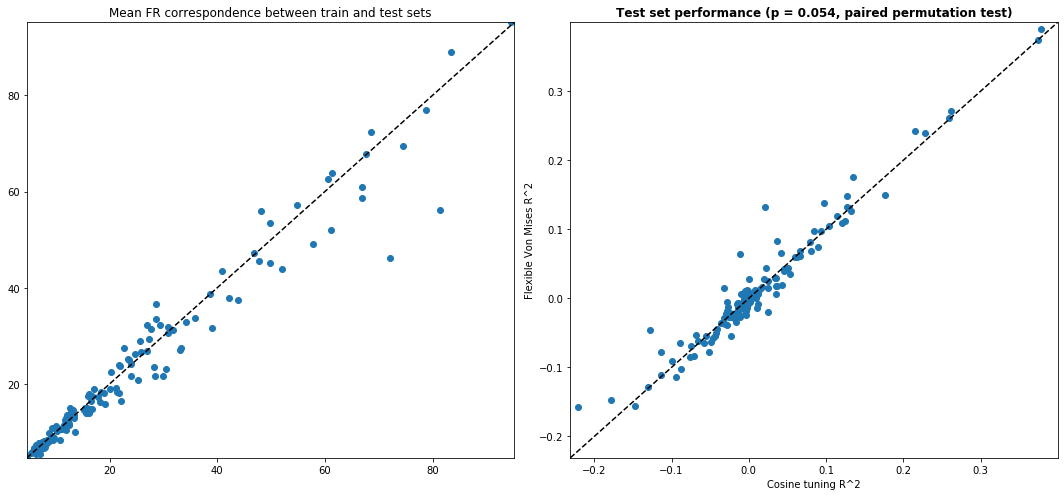

In [27]:
from permutation import signTest

figSize(7, 15)
plt.subplot(1, 2, 1)
plt.scatter(mean_FRs[0, :], mean_FRs[2, :])
minval = np.min([mean_FRs[0, :].min(), mean_FRs[2, :].min()]) - 0.01
maxval = np.max([mean_FRs[0, :].max(), mean_FRs[2, :].max()]) + 0.01
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.plot(plt.xlim(), plt.xlim(), linestyle = '--', color = 'k')
plt.title('Mean FR correspondence between train and test sets')

# get performance on an entirely unseen test set:
cos_testscores = np.zeros((192,))
vm_testscores  = np.zeros((192,))

neural, _, vel_signal, _ = getTrainTest(dat, train_frac = 1, task = task)
neural                   = gaussian_filter1d(neural.astype('float'), 2, axis= 0)
vel_angle                = getAngles(vel_signal, returnFullAngle = True)
split                    = int(vel_angle.shape[0] / 2)
train_x, test_x          = vel_angle[:train], vel_angle[val:test]

for i in range(192):
    train_y           = neural[:train, i].astype('float')
    test_y            = neural[val:test, i].astype('float')
    
    cos               = CosineTuningModel().fit(train_x, train_y)
    cos_testscores[i] = cos.score(test_x, test_y)
    
   # vm                = FlexibleVonMisesModel(n_basis = opt_B, kappa = opt_K).fit(train_x, train_y)
    vm                = FlexibleVonMisesModel(n_basis = , kappa = 0.00001).fit(train_x, train_y)
    vm_testscores[i]  = vm.score(test_x, test_y)


plt.subplot(1, 2, 2)
plt.scatter(cos_testscores, vm_testscores)
minval = np.min([cos_testscores.min(), vm_testscores.min()]) - 0.01
maxval = np.max([cos_testscores.max(), vm_testscores.max()]) + 0.01
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.plot(plt.xlim(), plt.xlim(), linestyle = '--', color = 'k')
plt.xlabel('Cosine tuning R^2')
plt.ylabel('Flexible Von Mises R^2')

good    = np.logical_or(cos_testscores > 0, vm_testscores > 0)
pval, _ = signTest(vm_testscores[good], cos_testscores[good], permutations = 1000, tail = 'right')
#pval, _ = signTest(cos_testscores, vm_testscores, permutations = 10000, tail = 'left')
plt.title('Test set performance (p = ' + str(np.round(pval, 3)) + ', paired permutation test)', fontweight = 'bold')

plt.tight_layout()

In [30]:
## now run across all sessions:

#opt_B = 8
#opt_K = 0.01

train = 8000
val   = 8000
test  = 10000

tasks = ['keyboard']

diff_sessions = list()

for i in range(len(files)):
    dat            = DataStruct(files[i])
    session_tasks  = np.intersect1d(tasks, np.unique(dat.trialType)) # check if any of the requested task types are in this session
    
    if len(session_tasks) > -1:
        #task    = session_tasks[0]
        n_chans = dat.TX_continuous.shape[1]
        
        testscores               = np.zeros((2, n_chans,))
        neural, _, vel_signal, _ = getTrainTest(dat, train_frac = 1, task = None)  # pull neural and cursor data from trial type
        if neural.shape[0] >= test:
            subselect                = np.linalg.norm(vel_signal, axis = 1) != 0       # mask any NaNs from time periods where cursor not moving or directly on target
            neural                   = neural[subselect, :].astype('float')
            vel_angle                = getAngles(vel_signal[subselect], returnFullAngle = True) 

            train_x, test_x          = vel_angle[:train], vel_angle[val:test]
            for j in range(n_chans):
                train_y, test_y   = neural[:train, j], neural[val:test, j]
                cos               = CosineTuningModel().fit(train_x, train_y)
                vm                = FlexibleVonMisesModel(n_basis = 50, kappa = 0.0001).fit(train_x, train_y)
                
                testscores[0, j]  = cos.score(test_x, test_y)
                testscores[1, j]  = vm.score(test_x, test_y)
                
            diff_sessions.append(testscores)
            
diff_sessions = np.stack(diff_sessions)

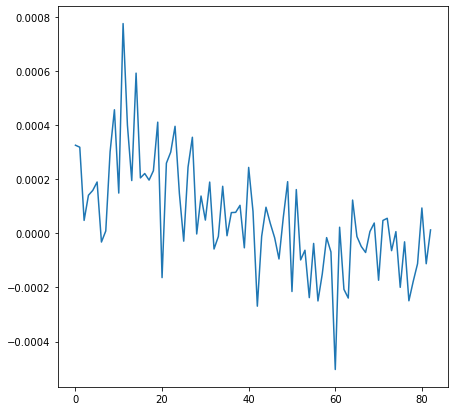

In [32]:
plt.plot(np.median(diff_sessions[:, 1, :] - diff_sessions[:, 0, :], axis = 1))